In [1]:
!conda info


     active environment : base
    active env location : /lfs/emanuelezappala.isu/miniconda3
            shell level : 1
       user config file : /lfs/emanuelezappala.isu/.condarc
 populated config files : 
          conda version : 23.3.1
    conda-build version : not installed
         python version : 3.8.16.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=12.4=0
                          __glibc=2.28=0
                          __linux=4.18.0=0
                          __unix=0=0
       base environment : /lfs/emanuelezappala.isu/miniconda3  (writable)
      conda av data dir : /lfs/emanuelezappala.isu/miniconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package c

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import logging
import warnings
from typing import Callable, Optional, Union
import os, argparse

import numpy as np
import torch

from scipy import integrate
import time
import pickle
from torch.utils.data import Dataset

logger = logging.getLogger("iesolver")
logger.setLevel(logging.WARNING)#(logging.DEBUG)

import matplotlib.pyplot as plt


import torchcubicspline
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)
                             
#from torchdiffeq import odeint


from source.integrators import MonteCarlo 
mc = MonteCarlo()

from source.model import F_NN, basis, Leray_Schauder, Leray_Schauder_model,\
interpolated_func, ConvNeuralNet1D, Simple_NN, custom_mui, ConvNeuralNet, Decoder_NN

from source.utils import fix_random_seeds,to_np,flatten_parameters

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
   
    
parser = argparse.ArgumentParser(description='Leray_Schauder')
parser.add_argument('-root_path', metavar='DIR', default='',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='stl10',
                    help='dataset name', choices=['acrobot_dataset'])

parser.add_argument('-j', '--workers', default=12, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=3000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=20, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true',
                    help='Whether or not to use 16-bit precision GPU training.')

parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=100, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')
parser.add_argument('--gpu-index', default=0, type=int, help='Gpu index.')
parser.add_argument('--model', default='simclr', choices=['simclr','lipschitz_simclr','vae','gan'], 
                    help='Models to be used')
parser.add_argument('--mode', default='train', choices=['train','evaluate'], 
                    help='Set to ''evaluate'' if inference is desired')
parser.add_argument('--training_split', default=0.25,type=float, 
                    help='Fraction of the samples that will be used for validation')
parser.add_argument('--resume_from_checkpoint', default=None, 
                    help='Give string to run number. Ex: "run12"')
parser.add_argument('--plot_freq', default=1, type=int,help='')
parser.add_argument('--experiment_name', default=None,help='')

_StoreAction(option_strings=['--experiment_name'], dest='experiment_name', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='', metavar=None)

In [4]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from source.experiments import burgers_experiment

use_cuda = torch.cuda.is_available()

In [5]:
use_cuda

True

In [6]:
from functools import reduce
import random
import pickle
import time

In [7]:
args = parser.parse_args("")
args.model='Leray_Schauder'
args.mode='train'
args.mode='evaluate'
#args.dataset_name = 'burgers'
args.seed = 7
args.experiment_name = 'burgers'
args.plot_freq = 50
args.device = device
args.num_dim_plot = 2
args.lr = 1e-4 #-4
args.min_lr=1e-9 #-9
args.T_max = 51 #51
args.plat_patience = 10
args.factor = 0.1
# args.temperature=0.001
#args.lr_scheduler = 'ReduceLROnPlateau'
args.lr_scheduler = 'CosineAnnealingLR'
args.resume_from_checkpoint = 'run144'
fix_random_seeds(args.seed)
args.perturbation_to_obs0=None
args.training_split=0.2
args.smoothing_factor= .5
if args.mode == 'train':
    args.n_batch = 16 #16
else:
    args.n_batch = 1
args.n_basis =  8 #8
args.patience =  1000
args.support_tensors=False
args.support_test=False
args.dim = 2
args.time_points = 10
#args.f_nn = True
args.max_iterations = 3
args.interpolation = False
args.channels = 256 #128,256
args.N_MC = 5120
#args.downsample = 10
#args.downsample_orig_data = 10
#args.generate_segments = True
#args.plot_train = False
args.train_epsilon = False

In [8]:
import pandas as pd
import mat73, scipy

In [9]:
burgers_t=args.time_points
args.burgers_t=burgers_t
args.downsample=int(burgers_t/2)

In [10]:
if args.mode=='train':
    Data = torch.load('Burgers/Burgers_1k_t400')
    Data = Data[...,1:]
else:
    print('loading test set')
    Data = scipy.io.loadmat('Burgers/Burgers_Data_N200_t400.mat')
    X = Data['output']
    Data = X[:,1:,:]
    Data = torch.from_numpy(Data).permute(0,2,1)

loading test set


In [11]:
Data.shape

torch.Size([200, 1024, 400])

In [12]:
t_max = 1 
t_min = 0
n_points = 256
args.n_points = n_points

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack(index_np[:, None])
times_np = np.linspace(t_min, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])

###########################################################
times = torch.from_numpy(times_np[:, :, None]).to(device)
times = times.flatten().float()
###########################################################
args.time_interval=t_min, t_max


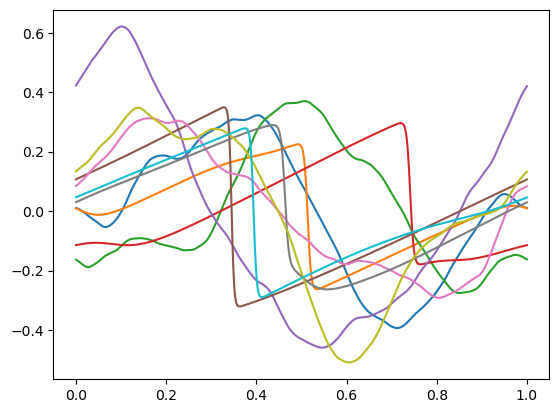

In [13]:
for i in range(5):
    plt.plot(torch.linspace(0,1,Data.shape[-2]),Data[i,:,0])
    plt.plot(torch.linspace(0,1,Data.shape[-2]),Data[i,:,-1])

In [14]:
Data_reshape = Data.flatten(start_dim=1, end_dim=-1)

In [15]:
Data_reshape.shape

torch.Size([200, 409600])

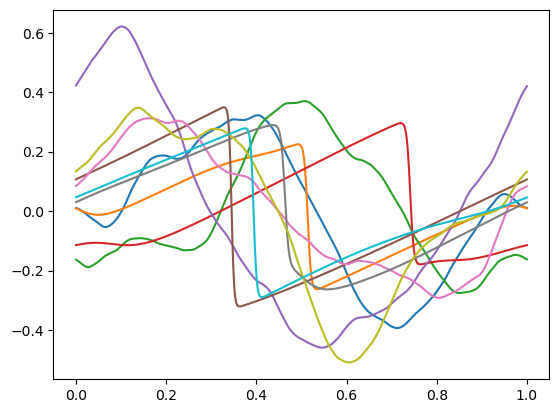

In [16]:
for i in range(5):
    plt.plot(torch.linspace(0,1,Data.shape[-2]),Data_reshape[i,::400])
    plt.plot(torch.linspace(0,1,Data.shape[-2]),Data_reshape[i,399::400])

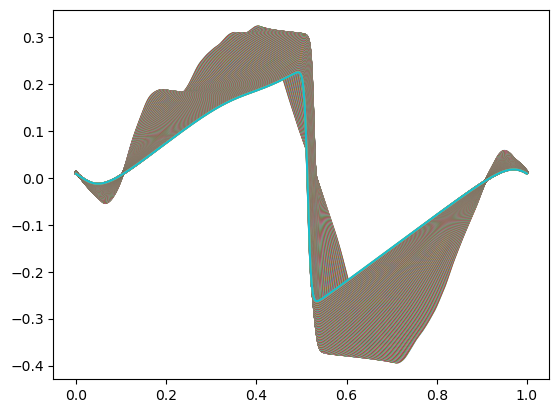

In [17]:
for i in range(Data.shape[-1]):
    plt.plot(torch.linspace(0,1,Data.shape[-2]),Data[0,:,i])

In [18]:
Data = Data.to(device)

In [19]:
Data = Data.float()

In [20]:
ids = np.tile(np.linspace(0,Data.shape[1]-1,num=n_points, dtype=np.int64),(Data.shape[1],1))

In [21]:
ids[0]

array([   0,    4,    8,   12,   16,   20,   24,   28,   32,   36,   40,
         44,   48,   52,   56,   60,   64,   68,   72,   76,   80,   84,
         88,   92,   96,  100,  104,  108,  112,  116,  120,  124,  128,
        132,  136,  140,  144,  148,  152,  156,  160,  164,  168,  172,
        176,  180,  184,  188,  192,  196,  200,  204,  208,  212,  216,
        220,  224,  228,  232,  236,  240,  244,  248,  252,  256,  260,
        264,  268,  272,  276,  280,  284,  288,  292,  296,  300,  304,
        308,  312,  316,  320,  324,  328,  332,  336,  341,  345,  349,
        353,  357,  361,  365,  369,  373,  377,  381,  385,  389,  393,
        397,  401,  405,  409,  413,  417,  421,  425,  429,  433,  437,
        441,  445,  449,  453,  457,  461,  465,  469,  473,  477,  481,
        485,  489,  493,  497,  501,  505,  509,  513,  517,  521,  525,
        529,  533,  537,  541,  545,  549,  553,  557,  561,  565,  569,
        573,  577,  581,  585,  589,  593,  597,  6

In [22]:
Data = Data[:,ids[0],:]

In [23]:
Data.shape

torch.Size([200, 256, 400])

In [24]:
t_ids = np.tile(np.linspace(1,Data.shape[-1]-1,num=burgers_t, dtype=np.int64),(Data.shape[1],1))

In [25]:
t_ids[0]

array([  1,  45,  89, 133, 177, 222, 266, 310, 354, 399])

In [26]:
Data = Data[:,:,t_ids[0]]

In [27]:
Data.shape

torch.Size([200, 256, 10])

In [28]:
ts_integration = torch.linspace(0,1,400)[t_ids[0]]
print(ts_integration)
args.ts_integration = ts_integration

tensor([0.0025, 0.1128, 0.2231, 0.3333, 0.4436, 0.5564, 0.6667, 0.7769, 0.8872,
        1.0000])


In [29]:
spacetime_domain_xt = torch.meshgrid([torch.linspace(0,1,n_points), torch.linspace(0,1,burgers_t)])
        
x_space = spacetime_domain_xt[0].flatten().unsqueeze(-1)
t_space = spacetime_domain_xt[1].flatten().unsqueeze(-1)

spacetime_domain = torch.cat([x_space,t_space],-1).to(device)

/lfs/emanuelezappala.isu/miniconda3/envs/Spectr/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [30]:
spacetime_domain.shape

torch.Size([2560, 2])

In [31]:
smoothing = nn.Sigmoid()

In [32]:
epsilon = 2.

In [33]:
Basis = basis(args.dim,args.channels,n=args.n_basis,shapes=[128,128],batch_size=args.n_batch).to(device) #[128,128]

In [34]:
norm_nn = None

In [35]:
encoder = Simple_NN(1,args.channels,[128,128]).to(device) #[128,128]

In [36]:
mui = custom_mui(args.channels,args.channels,hidden_dim=52,hidden_ff=104,K1=[(16,2),(16,2)],K2=[(16,2),(16,2)]).to(device) 
#hidden_dim=50, hidden_ff=100 (also 52, 104 is slightly better)
#K1=[(16,2),(16,2)],K2=[(16,2),(16,2)]

In [37]:
mui(torch.rand(4,256,args.time_points,args.channels).to(device)).shape

torch.Size([4, 256])

In [38]:
LS = Leray_Schauder(Basis,
                    dim=args.dim,
                    epsilon=epsilon,
                    integration_domain = [[0,1],[0,1]],
                    channels=args.channels,
                    N=args.N_MC,
                    batch_size=args.n_batch,
                    norm_type = 'custom',
                    norm_nn = norm_nn,
                    mui = mui,
                    train_epsilon = args.train_epsilon,
                    grid = spacetime_domain,
                    softmax = False
                    ).to(device)

In [39]:
proj_operator = F_NN(args.n_basis*args.channels,args.n_basis*args.channels,[128,128]).to(device) #[128,128]

In [40]:
model = Leray_Schauder_model(LS,proj_operator,batch_size=args.n_batch).to(device)

In [41]:
decoder = Simple_NN(args.channels,1,[128,128]).to(device) #[128,128]

In [42]:
flatten_parameters(model)+flatten_parameters(encoder)+flatten_parameters(decoder)

1592081

In [43]:
args.range_imshow = np.array([np.quantile(to_np(Data).flatten(), 0.05), np.quantile(to_np(Data).flatten(), 0.95)])


In [44]:
args.range_imshow

array([-0.36973135,  0.36170413])

In [45]:
args.epochs = 5000 

In [46]:
burgers_experiment(model, Data, encoder, decoder, spacetime_domain, args)

Loading  Leray_Schauder/burgers/run144/model
Running in evaluation mode


  0%|          | 0/200 [00:00<?, ?it/s]

(0.0017457377012033248, tensor(0.0012))

In [47]:
#Best (model 133) s256, t10: (0.001748820523134782, tensor(0.0012))

In [48]:
#Best (model 144) s256, t10: (0.0017457377012033248, tensor(0.0012))
